## 4. Time series as features



In [1]:
# Setup notebook
from pathlib import Path


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [3]:
data_path="../data/store_sales/train.csv.zip"

store_sales = pd.read_csv(
    data_path,
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

In [4]:
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

Not every product family has sales showing cyclic behavior, and neither does the series of average sales. Sales of school and office supplies, however, show patterns of growth and decay not well characterized by trend or seasons. In this question and the next, you'll model cycles in sales of school and office supplies using lag features.

Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely cyclic behavior, we'll start by deseasonalizing the series. Use the code in the next cell to deseasonalize Supply Sales. We'll store the result in a variable y_deseason.

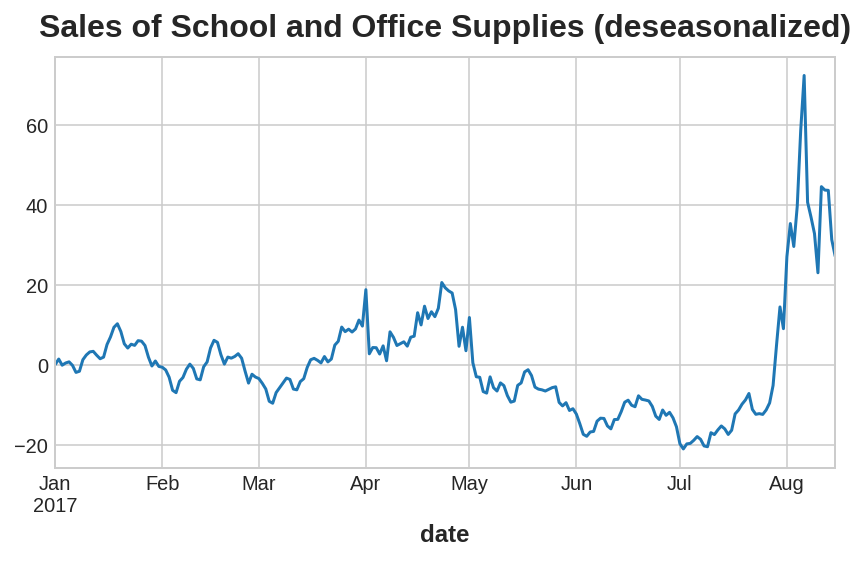

In [5]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

Does this deseasonalized series show cyclic patterns? To confirm our intuition, we can try to isolate cyclic behavior using a moving-average plot just like we did with trend. The idea is to choose a window long enough to smooth over short-term seasonality, but short enough to still preserve the cycles.

## 4.1 Plotting cycles

Create a seven-day moving average from `y`, the series of supply sales. Use a centered window, but don't set the `min_periods` argument.